In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load the data
df = pd.read_csv('parking_demand_2024.csv')

In [17]:
# Data Exploration
print(df.head())
print(df.info())
print(df.describe())

            timestamp  hour  day_of_week  baseline_demand  weather  traffic  \
0 2023-01-01 00:00:00     0            6                7        2       23   
1 2023-01-01 01:00:00     1            6                4        1        1   
2 2023-01-01 02:00:00     2            6                3        0       78   
3 2023-01-01 03:00:00     3            6                3        2       38   
4 2023-01-01 04:00:00     4            6                7        0       71   

   event  total_demand  optimal_price  month  day  is_weekend  
0      0             5           2.00      1    1           1  
1      0             5           2.56      1    1           1  
2      0             3           2.93      1    1           1  
3      0             2           2.22      1    1           1  
4      0             7           2.95      1    1           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 12 columns):
 #   Column           Non-Null C

In [5]:
# Feature Engineering
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [7]:
# Prepare features and target
features = [
    'hour', 'day_of_week', 'baseline_demand', 'weather', 'traffic',
    'event', 'total_demand', 'month', 'day', 'is_weekend'
]
X = df[features]
y = df['optimal_price']

In [9]:
# Train or load model
model_filename = 'parking_price_predictor.pkl'

if os.path.exists(model_filename):
    pipeline = joblib.load(model_filename)
    print(" Loaded pre-trained model.")
else:
    print("⚙️ Training new model...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    pipeline.fit(X_train, y_train)
    joblib.dump(pipeline, model_filename)

    # Evaluation
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)

    print("\n📊 Model Performance:")
    print(f"Train MAE: {mean_absolute_error(y_train, train_pred):.2f}")
    print(f"Test MAE: {mean_absolute_error(y_test, test_pred):.2f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.2f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.2f}")


 Loaded pre-trained model.


In [11]:
# Function to collect user input
def get_user_input():
    print("\n🧾 Enter the following details to predict parking price:")

    def get_input(prompt, cast_type, condition=lambda x: True, error_msg="Invalid input"):
        while True:
            try:
                value = cast_type(input(prompt))
                if condition(value):
                    return value
                print(error_msg)
            except ValueError:
                print("Please enter a valid value.")

    hour = get_input("Hour of the day (0-23): ", int, lambda x: 0 <= x <= 23)
    day_of_week = get_input("Day of the week (0=Mon, ..., 6=Sun): ", int, lambda x: 0 <= x <= 6)
    baseline_demand = get_input("Baseline demand (e.g., 20.0): ", float, lambda x: x >= 0)
    print("\nWeather Options:\n0 = Normal, 1 = Rain, 2 = Sunny")
    weather = get_input("Weather condition: ", int, lambda x: x in [0, 1, 2])
    traffic = get_input("Traffic level (0–100): ", int, lambda x: 0 <= x <= 100)
    print("\nSpecial Event? (0 = No, 1 = Yes)")
    event = get_input("Is there a special event? ", int, lambda x: x in [0, 1])
    total_demand = get_input("Total observed demand: ", float, lambda x: x >= 0)
    month = get_input("Month (1–12): ", int, lambda x: 1 <= x <= 12)
    day = get_input("Day of month (1–31): ", int, lambda x: 1 <= x <= 31)

    return hour, day_of_week, baseline_demand, weather, traffic, event, total_demand, month, day


In [13]:
# Prediction function
def predict_optimal_price(hour, day_of_week, baseline_demand, weather, traffic, event, total_demand, month, day):
    is_weekend = 1 if day_of_week in [5, 6] else 0
    input_data = pd.DataFrame([[
        hour, day_of_week, baseline_demand, weather, traffic,
        event, total_demand, month, day, is_weekend
    ]], columns=features)

    model = joblib.load(model_filename)
    prediction = model.predict(input_data)
    return prediction[0]


In [15]:
# Main Execution
if __name__ == "__main__":
    print("\n🏢 Parking Price Prediction System")
    print("---------------------------------")

    while True:
        user_inputs = get_user_input()
        price = predict_optimal_price(*user_inputs)
        print(f"\n📈 Predicted Optimal Parking Price: ${price:.2f}")

        another = input("\n Predict another price? (y/n): ").lower()
        if another != 'y':
            print("\n Thank you for using the Parking Price Prediction System!")
            break



🏢 Parking Price Prediction System
---------------------------------

🧾 Enter the following details to predict parking price:


Hour of the day (0-23):  5
Day of the week (0=Mon, ..., 6=Sun):  4
Baseline demand (e.g., 20.0):  10



Weather Options:
0 = Normal, 1 = Rain, 2 = Sunny


Weather condition:  0
Traffic level (0–100):  50



Special Event? (0 = No, 1 = Yes)


Is there a special event?  0
Total observed demand:  70
Month (1–12):  6
Day of month (1–31):  30



📈 Predicted Optimal Parking Price: $8.75



 Predict another price? (y/n):  n



 Thank you for using the Parking Price Prediction System!


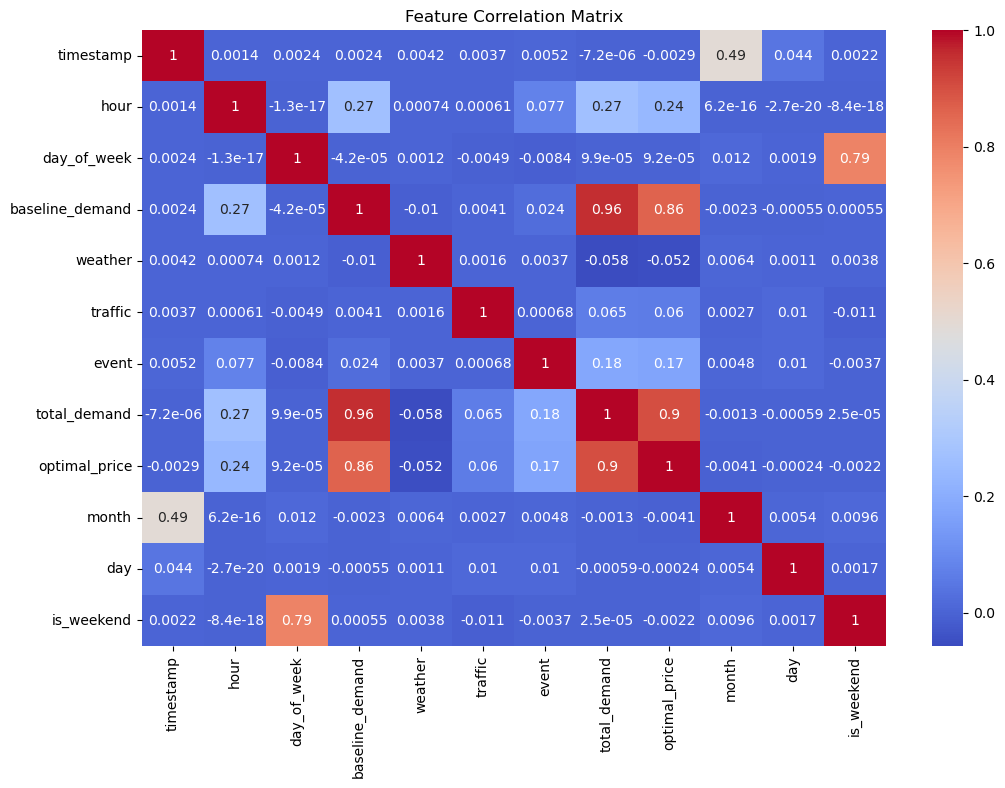

Train MAE: 0.15
Test MAE: 0.40
Train RMSE: 0.18
Test RMSE: 0.50

Feature Importances:
           feature  importance
6     total_demand    0.823768
4          traffic    0.048249
8              day    0.037645
7            month    0.027260
0             hour    0.025821
1      day_of_week    0.019029
2  baseline_demand    0.011687
3          weather    0.004166
9       is_weekend    0.002341
5            event    0.000035


In [19]:

# Feature Engineering
# Extract additional time features from timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Prepare features and target
features = ['hour', 'day_of_week', 'baseline_demand', 'weather', 'traffic', 'event', 'total_demand', 'month', 'day', 'is_weekend']
X = df[features]
y = df['optimal_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate model
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

print(f"Train MAE: {mean_absolute_error(y_train, train_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, test_pred):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.2f}")

# Feature importance
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Save model for future use
joblib.dump(pipeline, 'parking_price_predictor.pkl')

# Function to predict in real-time
def predict_optimal_price(hour, day_of_week, baseline_demand, weather, traffic, event, total_demand, month, day):
    """Predict optimal parking price based on real-time factors"""
    # Load the trained model
    model = joblib.load('parking_price_predictor.pkl')
    
    # Create input dataframe
    input_data = pd.DataFrame([[hour, day_of_week, baseline_demand, weather, traffic, event, total_demand, month, day, int(day_of_week in [5, 6])]],
                            columns=features)
    
    # Make prediction
    prediction = model.predict(input_data)
    return prediction[0]
